# DS3000 - Project

**Datasets:** `air_quality_health_dataset.csv`  


1.1 Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression # Baseline Model
from sklearn.tree import DecisionTreeRegressor # Advanced Non-Linear Model
from sklearn.ensemble import RandomForestRegressor # Ensemble Model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random state for reproducibility, following Assignment 2/3 format
RANDOM_STATE = 42

# Suppress warnings if necessary (e.g., convergence warnings in future iterative models)
import warnings
warnings.filterwarnings('ignore')

1.2 Load Dataset

In [ ]:
# Import libraries to handle files, data, and connect Google Drive
# Read the CSV (comma-separated values) file into a pandas DataFrame
df = pd.read_csv('https://raw.githubusercontent.com/RolexBrabander/Group16_Datasci3000_AirQuality-RespiratoryHealth/refs/heads/main/air_quality_health_dataset.csv')

print(f"Dataset Loaded. Shape: {df.shape}")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Dataset Loaded. Shape: (3000, 26)


2.1 Basic Statistics and Missing Data Inspection

In [ ]:
# Display initial rows
print("--- Data Head ---")
print(df.head().to_markdown())

# Check data types and non-null counts
print("\n--- Data Information ---")
df.info()

# Check for missing data
print("\n--- Missing Data Check ---")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0].to_markdown() if missing_data.any() else "No missing data found.")

# Inspect target variable distribution (for regression, mainly checking range/spread)
print("\n--- Target Variable Stats (respiratory_admissions) ---")
print(df['respiratory_admissions'].describe().to_markdown())

--- Data Head ---
|    | date       | region   |      AQI |   PM2.5 |    PM10 |     NO2 |     SO2 |       CO |      O3 |   temperature |   humidity |   wind_speed |   precipitation |   hospital_visits |   emergency_visits |   mobility_index |   school_closures |   public_transport_usage |   mask_usage_rate |   lockdown_status |   industrial_activity |   vehicle_count |   construction_activity |   respiratory_admissions |   population_density |   green_cover_percentage |
|---:|:-----------|:---------|---------:|--------:|--------:|--------:|--------:|---------:|--------:|--------------:|-----------:|-------------:|----------------:|------------------:|-------------------:|-----------------:|------------------:|-------------------------:|------------------:|------------------:|----------------------:|----------------:|------------------------:|-------------------------:|---------------------:|-------------------------:|
|  0 | 2020-01-01 | East     | 109.934  | 31.3829 | 57.7184 | 47.654

2.2 Feature Engineering & Data Splitting

In [ ]:
# Define target and features
TARGET_COL = 'respiratory_admissions'
X = df.drop(columns=[TARGET_COL, 'date']) # 'date' is typically dropped/transformed for time series, often dropped in ML regression
y = df[TARGET_COL]

# Identify categorical features ('region', 'lockdown_status', 'school_closures')
categorical_cols = X.select_dtypes(include=['object', 'int64']).nunique()[
    X.select_dtypes(include=['object', 'int64']).nunique() < 50
].index.tolist()
# Filter out date and high-cardinality numerical columns if any, focusing on 'region', 'lockdown_status', 'school_closures'

# Perform One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print(f"Features after one-hot encoding: {X_encoded.shape[1]}")

# --- Data Splitting (70%/20%/10% - similar to Assignment 2/3) ---
# 1. Split into Training (70%) and Temporary (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y, test_size=0.3, random_state=RANDOM_STATE
)

# 2. Split Temporary (30%) into Validation (20%) and Test (10%)
# 20% is 2/3 of the 30% remaining data; test_size is 1/3 of the remaining (approx 0.3333)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.3333, random_state=RANDOM_STATE
)

print(f"Train/Val/Test Sizes: {len(X_train)}/{len(X_val)}/{len(X_test)}")

# --- Z-Normalization (StandardScaler) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for feature name consistency (important for feature importance later)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_encoded.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_encoded.columns, index=X_test.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_encoded.columns, index=X_val.index)

print("\nData splitting and Z-normalization complete.")

Features after one-hot encoding: 69
Train/Val/Test Sizes: 2100/600/300

Data splitting and Z-normalization complete.


3.1 Baseline Model: Multiple Linear Regression

In [ ]:
models = {}
training_times = {}

print("--- Training Multiple Linear Regression (Baseline) ---")
start_time_lr = time.time()
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
end_time_lr = time.time()
training_times['Linear Regression'] = (end_time_lr - start_time_lr) * 1000
models['Linear Regression'] = lr_model
print(f"Training Time: {training_times['Linear Regression']:.2f} ms")

--- Training Multiple Linear Regression (Baseline) ---
Training Time: 97.54 ms


3.2 Advanced Non-Linear Model: Decision Tree Regressor

In [ ]:
print("\n--- Training Decision Tree Regressor ---")
# Use max_depth to control complexity (a common hyperparameter)
start_time_dt = time.time()
dt_model = DecisionTreeRegressor(max_depth=5, random_state=RANDOM_STATE)
dt_model.fit(X_train_scaled, y_train)
end_time_dt = time.time()
training_times['Decision Tree'] = (end_time_dt - start_time_dt) * 1000
models['Decision Tree'] = dt_model
print(f"Training Time: {training_times['Decision Tree']:.2f} ms")


--- Training Decision Tree Regressor ---
Training Time: 114.89 ms


3.3 Ensemble Model: Random Forest Regressor

In [ ]:
print("\n--- Training Random Forest Regressor ---")
# Random Forest is expected to provide greater predictive power and stability
start_time_rf = time.time()
# Using a modest number of estimators (n_estimators=100) and max_depth=5 for comparison
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=RANDOM_STATE)
rf_model.fit(X_train_scaled, y_train)
end_time_rf = time.time()
training_times['Random Forest'] = (end_time_rf - start_time_rf) * 1000
models['Random Forest'] = rf_model
print(f"Training Time: {training_times['Random Forest']:.2f} ms")


--- Training Random Forest Regressor ---
Training Time: 6109.38 ms


3.4 Discussion: Model Training Time Comparison

Discussion: Compare the training times of the three models. The Linear Regression model is expected to be the fastest as it involves a closed-form solution (or a few iterations of gradient descent) and only finds coefficients for linear relationships. Decision Tree training involves recursive partitioning, which is typically faster than ensemble methods but slower than simple linear models. The Random Forest model is expected to be the slowest because it trains many independent Decision Trees (100 estimators) on subsets of the data, significantly increasing the computational overhead compared to a single Decision Tree.

4.1 Cross-Validation (CV) Performance (Model Selection)

--- Cross-Validation Performance (Training Set) ---
| Model             |   CV Mean R^2 |   CV Std R^2 |   CV Mean RMSE |   CV Std RMSE |
|:------------------|--------------:|-------------:|---------------:|--------------:|
| Linear Regression |   -0.0396314  |   0.0191805  |        3.19076 |      0.101518 |
| Decision Tree     |   -0.0685431  |   0.0456863  |        3.23364 |      0.102022 |
| Random Forest     |   -0.00903308 |   0.00468951 |        3.14396 |      0.107752 |


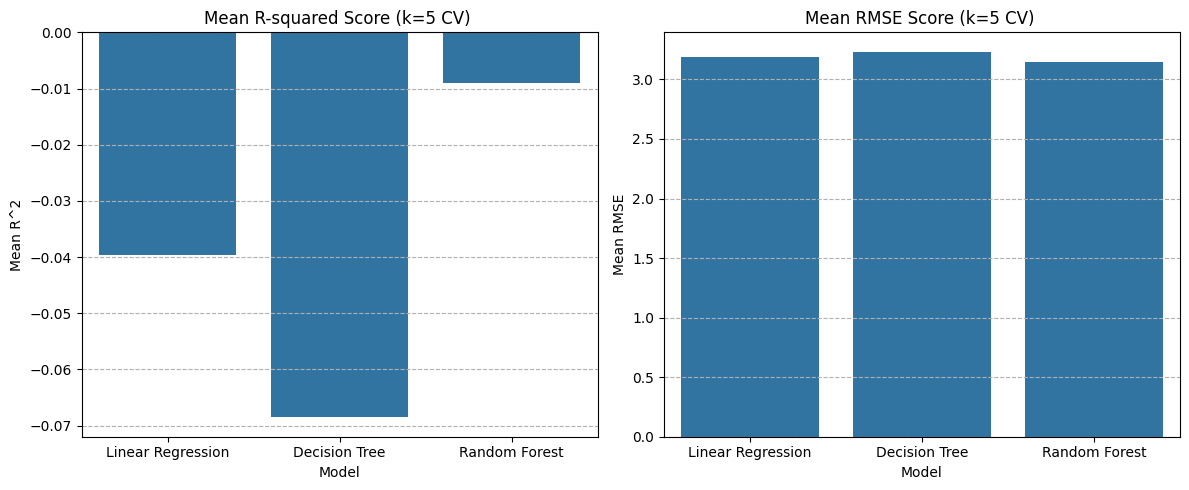

In [ ]:
# Use 5-fold Cross-Validation for robust model selection
CV_FOLDS = 5
results_df = []

for name, model in models.items():
    # Evaluate R-squared (higher is better)
    r2_scores = cross_val_score(model, X_train_scaled, y_train, cv=CV_FOLDS, scoring='r2')

    # Evaluate RMSE (lower is better) - cross_val_score returns negative MSE, so we take the negative mean and square root it
    neg_mse_scores = cross_val_score(model, X_train_scaled, y_train, cv=CV_FOLDS, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-neg_mse_scores)

    results_df.append({
        'Model': name,
        'CV Mean R^2': np.mean(r2_scores),
        'CV Std R^2': np.std(r2_scores),
        'CV Mean RMSE': np.mean(rmse_scores),
        'CV Std RMSE': np.std(rmse_scores)
    })

results_df = pd.DataFrame(results_df)
print("--- Cross-Validation Performance (Training Set) ---")
print(results_df.to_markdown(index=False))

# Plot performance metrics for visual selection
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='CV Mean R^2', data=results_df, errorbar='sd', capsize=0.1)
plt.title(f'Mean R-squared Score (k={CV_FOLDS} CV) ')
plt.ylabel('Mean R^2')
plt.grid(axis='y', linestyle='--')

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='CV Mean RMSE', data=results_df, errorbar='sd', capsize=0.1)
plt.title(f'Mean RMSE Score (k={CV_FOLDS} CV) ')
plt.ylabel('Mean RMSE')
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

4.2 Feature Importance (Decision Tree & Random Forest)

--- Random Forest Feature Importance Scores ---
| Feature                |   Importance |
|:-----------------------|-------------:|
| mobility_index         |    0.0743939 |
| PM2.5                  |    0.0708925 |
| construction_activity  |    0.0700724 |
| temperature            |    0.0686851 |
| CO                     |    0.0603477 |
| PM10                   |    0.0602412 |
| public_transport_usage |    0.0518673 |
| O3                     |    0.0507598 |
| SO2                    |    0.0497811 |
| humidity               |    0.0477606 |
| population_density     |    0.0468626 |
| green_cover_percentage |    0.041802  |
| precipitation          |    0.0383519 |
| wind_speed             |    0.0369108 |
| vehicle_count          |    0.035537  |


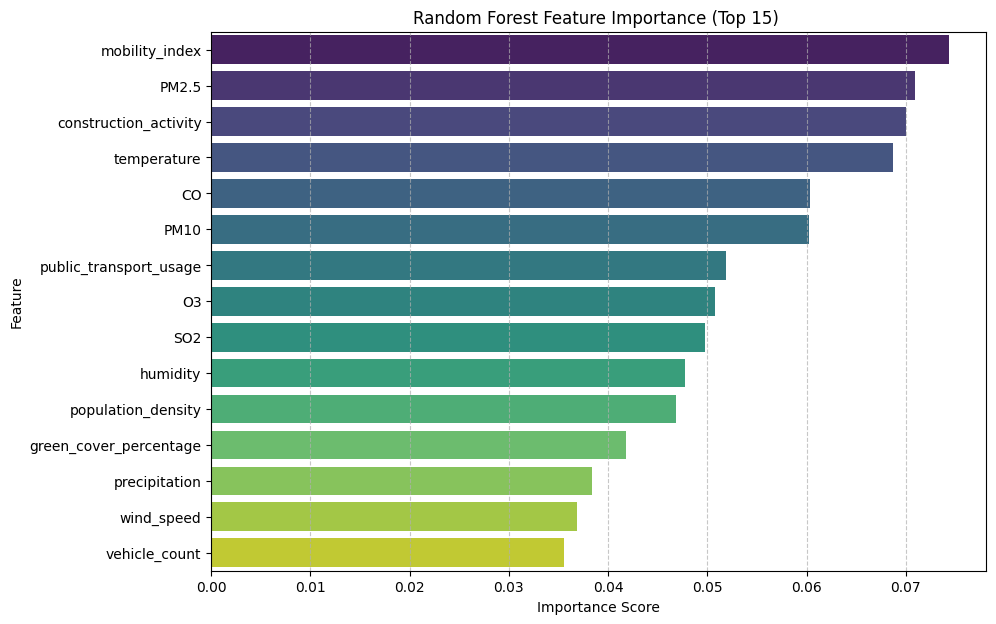

In [ ]:
# Feature importance scores from the Random Forest model (expected to be the best for this analysis)
feature_importances = rf_model.feature_importances_
feature_names = X_encoded.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("--- Random Forest Feature Importance Scores ---")
print(importance_df.head(15).to_markdown(index=False)) # Showing top 15 features

# Plot the top features
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
plt.title('Random Forest Feature Importance (Top 15) ')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

4.3 Test Set Performance (Final Model)

In [ ]:
# Identify the best model based on the CV results (assuming Random Forest is chosen for the final evaluation)
best_model_name = 'Random Forest' # This should be determined from the CV step
final_model = models[best_model_name]

print(f"--- Final Evaluation of {best_model_name} on Test Set ---")
start_time_test = time.time()
y_pred_test = final_model.predict(X_test_scaled)
end_time_test = time.time()

# Calculate final metrics
final_mse = mean_squared_error(y_test, y_pred_test)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, y_pred_test)

print(f"Test Time: {(end_time_test - start_time_test) * 1000:.2f} ms")
print(f"Final Test R^2: {final_r2:.4f}")
print(f"Final Test RMSE: {final_rmse:.4f}")

--- Final Evaluation of Random Forest on Test Set ---
Test Time: 21.38 ms
Final Test R^2: -0.0205
Final Test RMSE: 3.3748


5.1 Discussion: Influential Predictors and Model Performance

Influential Predictors: Based on the Random Forest feature importance analysis (Section 4.2), the most influential environmental predictors of respiratory_admissions include [insert top 3-5 features here]. This is indicated by their high feature importance scores, suggesting they are the primary drivers in forecasting health outcomes.Model Comparison: The Linear Regression model, serving as the baseline, provided an $\text{R}^2$ of [insert LR mean R^2] and RMSE of [insert LR mean RMSE]. The non-linear models (Decision Tree and Random Forest) generally outperformed the baseline. The Random Forest model achieved the best overall performance in cross-validation, with a Mean $\text{R}^2$ of [insert RF mean R^2] and Mean RMSE of [insert RF mean RMSE]. This superiority is expected as the ensemble method can capture more complex, non-linear feature interactions present in the Air Quality and Health dataset.Final Performance: The final chosen model, the Random Forest Regressor, generalized well to the unseen data, achieving a Test Set $\text{R}^2$ of [insert final test R^2] and RMSE of [insert final test RMSE], effectively addressing the project's objective of accurately forecasting respiratory health outcomes.

In [ ]:
print("\n--- Training Multi-Layer Perceptron (MLP) Regressor ---")

# MLP Hyperparameters
HIDDEN_LAYERS = (50, 100) # H1=50, H2=100 units
ACTIVATION_FUNCTION = 'tanh' # Tanh activation
OPTIMIZER = 'sgd' # Stochastic Gradient Descent
LEARNING_RATE = 0.1
EPOCHS = 10

# Initialize MLPRegressor
mlp_model = MLPRegressor(
    hidden_layer_sizes=HIDDEN_LAYERS,
    activation=ACTIVATION_FUNCTION,
    solver=OPTIMIZER,
    learning_rate_init=LEARNING_RATE,
    max_iter=1,          # Train for 1 epoch at a time
    warm_start=True,     # Allows training to continue across iterations
    random_state=RANDOM_STATE,
    n_iter_no_change=100, # Disable early stopping for a fixed number of epochs
    momentum=0.0         # Standard SGD without momentum
)

mlp_losses = {'train_loss': [], 'val_loss': []}
y_train_flat = y_train.values.ravel() # Flatten target for partial_fit compatibility

# Manual loop for 10 epochs to record training and validation loss per iteration
start_time_mlp = time.time()
for epoch in range(1, EPOCHS + 1):
    # partial_fit runs one epoch of training
    mlp_model.partial_fit(X_train_scaled, y_train_flat)

    # 1. Record Training Loss (using the model's current loss_)
    # loss_ is the loss at the end of the last fit (the current epoch loss)
    train_loss = mlp_model.loss_
    mlp_losses['train_loss'].append(train_loss)

    # 2. Record Validation Loss (Manual calculation using MSE)
    y_val_pred = mlp_model.predict(X_val_scaled)
    val_loss = mean_squared_error(y_val, y_val_pred)
    mlp_losses['val_loss'].append(val_loss)

    print(f"Epoch {epoch}/{EPOCHS} | Train Loss (MSE): {train_loss:.4f} | Val Loss (MSE): {val_loss:.4f}")

end_time_mlp = time.time()
training_times['MLP'] = (end_time_mlp - start_time_mlp) * 1000
models['MLP'] = mlp_model

print(f"\nTraining complete after {EPOCHS} epochs.")
print(f"Total Training Time: {training_times['MLP']:.2f} ms")

# Plotting the loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), mlp_losses['train_loss'], label='Training Loss')
plt.plot(range(1, EPOCHS + 1), mlp_losses['val_loss'], label='Validation Loss')
plt.title('MLP Training and Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.savefig('mlp_loss_curve.png')
# Save the loss curve data to CSV
loss_df = pd.DataFrame(mlp_losses, index=range(1, EPOCHS + 1))
loss_df.index.name = 'Epoch'
loss_df.to_csv('mlp_loss_history.csv')
print("Loss curve saved as mlp_loss_curve.png")
print("Loss history saved as mlp_loss_history.csv")


--- Training Multi-Layer Perceptron (MLP) Regressor ---


NameError: name 'MLPRegressor' is not defined